This notebook implements a simple version of this DDPG algorithm from https://arxiv.org/pdf/1509.02971.pdf

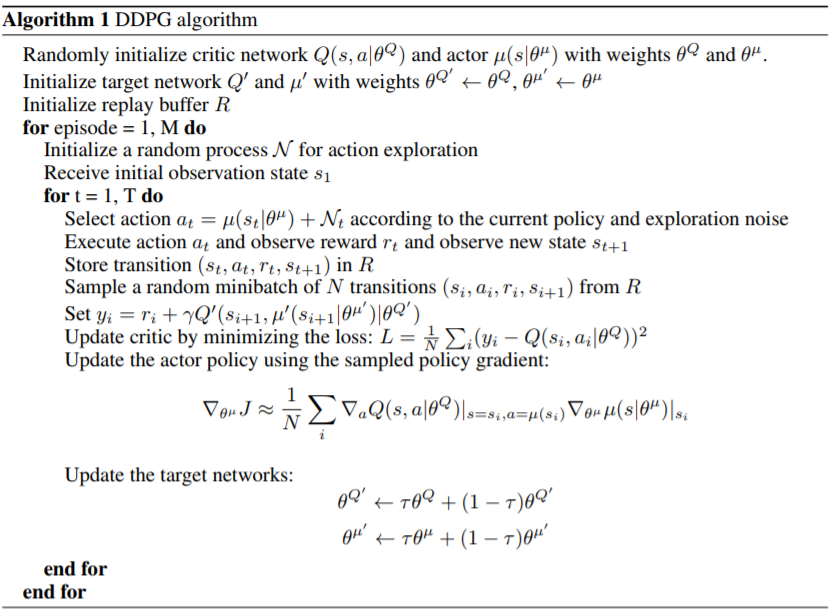

In [22]:
#DDPG from https://arxiv.org/pdf/1509.02971.pdf 
#create replay buffer memory
from collections import deque

replay_memory_size = 50
replay_memory = deque([], maxlen=replay_memory_size)
#input 5-tuple should look like these three examples below, in order for proper output as below
#test input
#replay_memory.append(([1.0, 1.0], 2.0, 3.0, [4.0, 4.0], 1))
#replay_memory.append(([5.0, 5.0], 6.0, 7.0, [8.0, 8.0], 1))
#replay_memory.append(([9.0, 9.0], 10.0, 11.0, [12.0, 12.0], 1))

def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1].reshape(-1, 1), cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

'''
#test function sample memories
X_state_val, X_action_val, rewards, X_next_state_val, continues = (sample_memories(batch_size=3))
print("X_state_val:\n", X_state_val)
print("X_action_val:\n", X_action_val)
print("rewards:\n", rewards)
print("X_next_state_val:\n", X_next_state_val )
print("continues:\n", continues)
'''
###########################################################################################################
eps_min = 0.0
eps_max = 1.0
eps_decay_steps = 100000

def exploration_noise(step_count):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step_count/eps_decay_steps)
    explore = False
    if np.random.rand() < epsilon:
        explore = True
    #temp = 0.8*(np.random.rand() - 0.5)
    temp = 0.4*(np.random.rand() - 0.5)
    return explore, temp  
###################################################################################################################
import tensorflow as tf
import numpy as np
import os
import gym
import time
import sklearn
import itertools

env = gym.envs.make("MountainCarContinuous-v0")

#critic and actor leanring rates
learning_rate_q = 0.00001    #0.00001
learning_rate_mu = 0.000001 #0.000001
#momentum = 0.95

tf.reset_default_graph()
initializer = tf.contrib.layers.variance_scaling_initializer()

######################################################################################################
# define actor network
n_inputs_a = 2
n_hidden1_a = 40  #20
n_hidden2_a = 40   #10
n_outputs_a = 1

dropout_rate = 0.25  # == 1 - keep_prob
training = tf.placeholder_with_default(False, shape=()) 

with tf.variable_scope("mu_networks/actor"):

    state_a = tf.placeholder(tf.float32, shape=[None, n_inputs_a], name="state_a")
    state_a_drop = tf.layers.dropout(state_a, dropout_rate, training=training)
    hidden1_a = tf.layers.dense(inputs=state_a_drop, units=n_hidden1_a, activation = tf.nn.elu, kernel_initializer = initializer)
    hidden1_a_drop = tf.layers.dropout(hidden1_a, dropout_rate, training=training)
    hidden2_a = tf.layers.dense(inputs=hidden1_a_drop, units=n_hidden2_a, activation = tf.nn.elu, kernel_initializer = initializer)
    hidden2_a_drop = tf.layers.dropout(hidden2_a, dropout_rate, training=training)
    mu = tf.layers.dense(inputs=hidden2_a_drop,units=n_outputs_a,activation=None,kernel_initializer = initializer)
    mu_activ = tf.tanh(mu)  
    
    optimizer_mu = tf.train.AdamOptimizer(learning_rate_mu)
    grads_and_vars = optimizer_mu.compute_gradients(mu_activ)   #gradients for use in policy gradient theorem
    gradients = [grad for grad, variable in grads_and_vars]
    gradient_placeholders = []
    grads_and_vars_feed = []
    for grad, variable in grads_and_vars:
        #print("shape:", grad.get_shape())
        #print("grad:", grad)
        gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
        gradient_placeholders.append(gradient_placeholder)
        grads_and_vars_feed.append((gradient_placeholder, variable))
    training_op_mu = optimizer_mu.apply_gradients(grads_and_vars_feed)
#############################################################################################################

trainable_vars_a = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="mu_networks/actor")
trainable_vars_by_name_a = {var.name[len("mu_networks/actor"):]: var for var in trainable_vars_a}

#create a copy of the actor network (the 'prime' network in the DDPG paper reference (p=prime))
with tf.variable_scope("mu_networks/actor_p"):
    state_ap = tf.placeholder(tf.float32, shape=[None, n_inputs_a], name="state_ap")
    hidden1_ap = tf.layers.dense(inputs=state_ap, units=n_hidden1_a, activation = tf.nn.elu, kernel_initializer = initializer)
    hidden2_ap = tf.layers.dense(inputs=hidden1_ap, units=n_hidden2_a, activation = tf.nn.elu, kernel_initializer = initializer)
    mu_p = tf.layers.dense(inputs=hidden2_ap,units=n_outputs_a,activation=None,kernel_initializer = initializer)
    mu_activ_p = tf.tanh(mu_p)
    
trainable_vars_ap = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="mu_networks/actor_p")
trainable_vars_by_name_ap = {var.name[len("mu_networks/actor_p"):]: var for var in trainable_vars_ap}

#create an op to copy the actor network to the primed (copy) actor network
copy_ops_actor = [target_var.assign(trainable_vars_by_name_a[var_name]) 
            for var_name, target_var in trainable_vars_by_name_ap.items()]
copy_unprimed_to_prime_actor = tf.group(*copy_ops_actor)

#create an op to partially copy the primed actor network to the un-primed actor network
tau = 0.1
tau_comp = 1.0 -tau
train_target_actor = [var_ap.assign(tf.add(tf.scalar_mul(tau,var_a), tf.scalar_mul(tau_comp,var_ap))) 
        for var_a, var_ap in zip(trainable_vars_a, trainable_vars_ap)]
train_target_actor_group = tf.group(*train_target_actor)

#############################################################################################
# define critic network

n_inputs_c = 3    # 2 state variables, 1 action variable (for continuous mountian car)
n_hidden1_c = 400     #50
n_hidden2_c = 400     #50
n_outputs_c = 1

training_q = tf.placeholder_with_default(False, shape=())  
with tf.variable_scope("q_networks/critic"):
    input_c = tf.placeholder(tf.float32, shape=[None, n_inputs_c], name="input_c")
    input_c_drop = tf.layers.dropout(input_c, dropout_rate, training=training_q)
    hidden1_c = tf.layers.dense(inputs=input_c_drop, units=n_hidden1_c, activation = tf.nn.elu, kernel_initializer = initializer)
    hidden1_c_drop = tf.layers.dropout(hidden1_c, dropout_rate, training=training_q)
    hidden2_c = tf.layers.dense(inputs=hidden1_c_drop, units=n_hidden2_c, activation = tf.nn.elu, kernel_initializer = initializer)
    hidden2_c_drop = tf.layers.dropout(hidden2_c, dropout_rate, training=training_q)
    q = tf.layers.dense(inputs=hidden2_c_drop, units=n_outputs_c, activation=None, kernel_initializer = initializer)
    #q_act = tf.tanh(q)
    
    y = tf.placeholder(tf.float32, shape=[None, 1])
    error = (y - q)
    loss = tf.reduce_mean(tf.square(error))
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.AdamOptimizer(learning_rate_q)  
    training_op = optimizer.minimize(loss, global_step=global_step)
    
    grad_q_wrt_action = tf.gradients(q, input_c)[0]   #the [0] converts resulting list [<tensor>] to <tensor>
#######################################################################################################################
trainable_vars_c = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="q_networks/critic")
trainable_vars_by_name_c = {var.name[len("q_networks/critic"):]: var for var in trainable_vars_c}

#create a copy of the critic network (the 'prime' network in the DDPG paper reference (p=prime))
with tf.variable_scope("q_networks/critic_p"):
    input_cp = tf.placeholder(tf.float32, shape=[None, n_inputs_c], name="input_c")
    hidden1_cp = tf.layers.dense(inputs=input_cp, units=n_hidden1_c, activation = tf.nn.elu, kernel_initializer = initializer)
    hidden2_cp = tf.layers.dense(inputs=hidden1_cp, units=n_hidden2_c, activation = tf.nn.elu, kernel_initializer = initializer)
    q_p = tf.layers.dense(inputs=hidden2_cp, units=n_outputs_c, activation=None, kernel_initializer = initializer)
    
trainable_vars_cp = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="q_networks/critic_p")
trainable_vars_by_name_cp = {var.name[len("q_networks/critic_p"):]: var for var in trainable_vars_cp}

#create an op to copy the critic network to the primed (copy) critic network
copy_ops_critic = [target_var.assign(trainable_vars_by_name_c[var_name]) 
            for var_name, target_var in trainable_vars_by_name_cp.items()]
copy_unprimed_to_prime_critic = tf.group(*copy_ops_critic)

#create an op to partially copy the primed critic network to the un-primed critic network
tau = 0.1
tau_comp = 1.0 -tau
train_target_critic = [var_cp.assign(tf.add(tf.scalar_mul(tau,var_c), tf.scalar_mul(tau_comp,var_cp))) 
        for var_c, var_cp in zip(trainable_vars_c, trainable_vars_cp)]
train_target_critic_group = tf.group(*train_target_critic)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
############################################################################################

import sklearn
import sklearn.pipeline
import sklearn.preprocessing

from collections import deque
replay_memory_size = 25000
replay_memory = deque([], maxlen=replay_memory_size)

noise_step = 0
exploration_state = 0
n_steps = 1000  # total number of training steps
training_start = 25000  # start training after 25,000 game iterations
training_interval = 1  # run a training step every n game iterations
save_steps = 1000  # save the model every 1,000 training steps
#copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
batch_size = 8
iteration = 0  # game iterations
checkpoint_path = "./my_ddpg.ckpt"
done = True # reset environment
cum_reward = 0.0
max_cum_reward = -100.0

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

###############################################################
#expects input state shape = (batch_dim,2)  
#returns output 'scaled' shape = (batch_dim,2)
def process_state(state):
    scaled = scaler.transform(state)
    return scaled  
#################################################################

with tf.Session() as sess:
    
    '''
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    '''
    init.run()
    copy_unprimed_to_prime_critic.run()
    copy_unprimed_to_prime_actor.run()
    #NEED to initialize replay memory buffer
    for loop_index in range(10000000):
    #while True:
        noise_step += 1
        step = global_step.eval()
        #print("global_step:", step)
        #if step >= n_steps:
            #break
        iteration += 1
        if done: # game over, start again
            #NEED to initialize a noise process; if exploration noise is used
            temp = max(cum_reward, max_cum_reward)
            max_cum_reward = temp
            training = tf.placeholder_with_default(True, shape=())   
            print("game ended. cum_reward = ", cum_reward, "noise step = ", noise_step, "max_cum_reward=", max_cum_reward)
            cum_reward = 0.0
            state = env.reset()   #state ->  shape = (2,)
        action_out  = mu_activ.eval(feed_dict={state_a: process_state([state])})  #may add exploration noise term to this
        action = action_out[0,0]
        #action is a scalar to pass to  replay_memory.append
        not_use_policy, noise_action = exploration_noise(noise_step)
        if not_use_policy:
            action = noise_action
            t1 = np.array(noise_action)
            action_out = t1.reshape(1,1)
    
        next_state, reward, done, _ = env.step(action_out[0])  #passing action_out[0] which is correct shape=(1,)
        cum_reward += reward
        replay_memory.append((state, action, reward, next_state, 1.0 - done)) 
        state = next_state 
        
        if iteration < training_start or max_cum_reward > 97.0 :
            continue
        X_state_val_unprocess, X_action_val, rewards, X_next_state_val_unprocess, continues = sample_memories(batch_size)
        X_state_val = process_state(X_state_val_unprocess)
        X_next_state_val = process_state(X_next_state_val_unprocess)
        q_input = np.concatenate((X_state_val, X_action_val), axis=1)  
        #shape q_input -> (batch_size, 3)
        next_mup_values = mu_activ_p.eval(feed_dict={state_ap: X_next_state_val})
        qp_next_input = np.concatenate((X_next_state_val, next_mup_values), axis=1)
        # shape qp_next_input -> (batch_size, 3)
        next_qp_values = q_p.eval(feed_dict={input_cp: qp_next_input})
        y_vals = rewards + (continues * discount_rate * next_qp_values)
        #Training
        _, loss_val = sess.run([training_op, loss], feed_dict={training_q: True, input_c: q_input, y: y_vals})
        mu_values = mu_activ.eval(feed_dict={state_a: X_state_val})
        
        q_grad_input = np.concatenate((X_state_val, mu_values), axis=1)  
        
        grad_q_wrt_action_vals = sess.run(grad_q_wrt_action, feed_dict={input_c: q_grad_input})
        
        all_gradients = []
        for batch_index in range(batch_size):
            grad_mu_wrt_network_vars_vals_ith = sess.run(gradients, feed_dict={state_a: [X_state_val[batch_index,:]]})
            all_gradients.append(grad_mu_wrt_network_vars_vals_ith)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):   #check if [batch_index][var_index] order correct
            policy_gradient = np.mean([ grad_q_wrt_action_vals[batch_index,2]*all_gradients[batch_index][var_index]
                                       for batch_index, grad_val in enumerate(all_gradients)],axis = 0)
            feed_dict[gradient_placeholder] = policy_gradient
        addtional_feed = {training: True}
        feed_dict.update(addtional_feed)
        sess.run(training_op_mu, feed_dict=feed_dict)
        
        train_target_actor_group.run()
        train_target_critic_group.run()
        
        # Regularly copy the online DQN to the target DQN
        #if step % copy_steps == 0:
            #copy_online_to_target.run()

        # And save regularly
        #if step % save_steps == 0:
            #saver.save(sess, checkpoint_path)


game ended. cum_reward =  0.0 noise step =  1 max_cum_reward= 0.0
game ended. cum_reward =  -1.313686317970511 noise step =  1000 max_cum_reward= 0.0
game ended. cum_reward =  -1.3993456398844093 noise step =  1999 max_cum_reward= 0.0
game ended. cum_reward =  -1.5346825424774186 noise step =  2998 max_cum_reward= 0.0
game ended. cum_reward =  -1.5066750231640693 noise step =  3997 max_cum_reward= 0.0
game ended. cum_reward =  -1.7910608202083043 noise step =  4996 max_cum_reward= 0.0
game ended. cum_reward =  -2.3271312090768137 noise step =  5995 max_cum_reward= 0.0
game ended. cum_reward =  -1.8205936099957303 noise step =  6994 max_cum_reward= 0.0
game ended. cum_reward =  -1.5024257061647317 noise step =  7993 max_cum_reward= 0.0
game ended. cum_reward =  -1.7084920311910452 noise step =  8992 max_cum_reward= 0.0
game ended. cum_reward =  -1.6811007403583926 noise step =  9991 max_cum_reward= 0.0
game ended. cum_reward =  -1.9372361905785618 noise step =  10990 max_cum_reward= 0.0

game ended. cum_reward =  97.04147972984363 noise step =  55960 max_cum_reward= 97.61747499414695
game ended. cum_reward =  97.12624200138286 noise step =  56677 max_cum_reward= 97.61747499414695
game ended. cum_reward =  97.25402452646446 noise step =  57094 max_cum_reward= 97.61747499414695
game ended. cum_reward =  97.26571903697973 noise step =  57350 max_cum_reward= 97.61747499414695
game ended. cum_reward =  96.77140022367527 noise step =  57701 max_cum_reward= 97.61747499414695
game ended. cum_reward =  97.60032974067094 noise step =  58025 max_cum_reward= 97.61747499414695
game ended. cum_reward =  96.78287096366613 noise step =  58344 max_cum_reward= 97.61747499414695
game ended. cum_reward =  95.88350810142727 noise step =  58915 max_cum_reward= 97.61747499414695
game ended. cum_reward =  97.62786659516632 noise step =  59192 max_cum_reward= 97.62786659516632
game ended. cum_reward =  97.44390198461647 noise step =  59505 max_cum_reward= 97.62786659516632
game ended. cum_rewa

game ended. cum_reward =  95.39205386311173 noise step =  83664 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.0206045085478 noise step =  83993 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.51376020364616 noise step =  84151 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.47103249867656 noise step =  84422 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.78620779829492 noise step =  84727 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.48254733380605 noise step =  84957 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.438129912495 noise step =  85151 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.67586415312263 noise step =  85526 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.52619072069001 noise step =  85694 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.13819265889677 noise step =  85931 max_cum_reward= 97.62814180814621
game ended. cum_reward 

game ended. cum_reward =  97.45028775052275 noise step =  104028 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.06039356702891 noise step =  104378 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.36167726914611 noise step =  104535 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.22813413505132 noise step =  104700 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.90781672231648 noise step =  104968 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.20573172284578 noise step =  105162 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.49682257262786 noise step =  105318 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.43858040279208 noise step =  105476 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.46410514847076 noise step =  105632 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.71405512786771 noise step =  106033 max_cum_reward= 97.62814180814621
game ended

game ended. cum_reward =  97.0259503976362 noise step =  122660 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.70783246481021 noise step =  122851 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.14612905534935 noise step =  123012 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.41267144602996 noise step =  123240 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.42951582782223 noise step =  123538 max_cum_reward= 97.62814180814621
game ended. cum_reward =  94.89317601547738 noise step =  123856 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.85720779123058 noise step =  124047 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.44332886288109 noise step =  124204 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.42968952518754 noise step =  124396 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.08078914713066 noise step =  124662 max_cum_reward= 97.62814180814621
game ended.

game ended. cum_reward =  96.54378432808089 noise step =  143068 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.15915886630282 noise step =  143312 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.3030363849546 noise step =  143541 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.4492106879559 noise step =  143697 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.4695631556731 noise step =  143855 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.68490122331647 noise step =  144091 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.27110363874067 noise step =  144275 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.54990714161622 noise step =  144502 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.35557464672725 noise step =  144659 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.39919839900682 noise step =  144853 max_cum_reward= 97.62814180814621
game ended. c

game ended. cum_reward =  97.3395630775844 noise step =  161834 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.89779823072017 noise step =  162312 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.04411462649455 noise step =  162544 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.41446938559952 noise step =  162772 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.34255299702218 noise step =  162934 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.17285835473209 noise step =  163164 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.25450626471083 noise step =  163357 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.37536975534103 noise step =  163552 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.93973608604492 noise step =  163743 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.38951322867652 noise step =  163935 max_cum_reward= 97.62814180814621
game ended.

game ended. cum_reward =  96.92626365765777 noise step =  180713 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.85866927331924 noise step =  180939 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.63138640602197 noise step =  181165 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.8995746764684 noise step =  181713 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.46464469160587 noise step =  181870 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.44851412663762 noise step =  182029 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.59712599402584 noise step =  182301 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.35301050058463 noise step =  182493 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.74157099059394 noise step =  182684 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.35644561733191 noise step =  182841 max_cum_reward= 97.62814180814621
game ended.

game ended. cum_reward =  97.4486355773842 noise step =  199388 max_cum_reward= 97.62814180814621
game ended. cum_reward =  94.89853523946489 noise step =  199671 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.46325119595222 noise step =  199898 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.32520675327557 noise step =  200230 max_cum_reward= 97.62814180814621
game ended. cum_reward =  94.88893535293602 noise step =  200513 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.72778060689373 noise step =  200949 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.98628990874451 noise step =  201317 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.33055952332374 noise step =  201500 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.74007773612912 noise step =  201901 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.66015787744654 noise step =  202092 max_cum_reward= 97.62814180814621
game ended.

game ended. cum_reward =  97.34865178989475 noise step =  218141 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.69915678386326 noise step =  218332 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.35666797590618 noise step =  218524 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.39369792822568 noise step =  218751 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.89199666457573 noise step =  218984 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.07599065311219 noise step =  219439 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.06943649180775 noise step =  219704 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.19869632339113 noise step =  219933 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.46781282181462 noise step =  220090 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.02983894429514 noise step =  220427 max_cum_reward= 97.62814180814621
game ended

game ended. cum_reward =  97.18522786658525 noise step =  237214 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.44427531228183 noise step =  237407 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.93045727213226 noise step =  237669 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.31619003843682 noise step =  237966 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.45035184168272 noise step =  238158 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.45753739570188 noise step =  238350 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.43235989420074 noise step =  238507 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.4443386571497 noise step =  238663 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.6369463046117 noise step =  238840 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.14891311435585 noise step =  239119 max_cum_reward= 97.62814180814621
game ended. 

game ended. cum_reward =  97.43422249497796 noise step =  255989 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.7724956468926 noise step =  256180 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.76051335603246 noise step =  256450 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.8343843771632 noise step =  256641 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.42966635009554 noise step =  256800 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.15358601484857 noise step =  256961 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.13848169296905 noise step =  257156 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.76386762199176 noise step =  257382 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.86811499532364 noise step =  257608 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.67860387174312 noise step =  257799 max_cum_reward= 97.62814180814621
game ended. 

game ended. cum_reward =  97.04597502492757 noise step =  274063 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.86816619044721 noise step =  274429 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.4630431730536 noise step =  274585 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.44370943816466 noise step =  274812 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.64888763819252 noise step =  275003 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.19458237753044 noise step =  275163 max_cum_reward= 97.62814180814621
game ended. cum_reward =  94.4645432933738 noise step =  275453 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.69882725709041 noise step =  275644 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.15901590287567 noise step =  275839 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.10048834580209 noise step =  276070 max_cum_reward= 97.62814180814621
game ended. 

game ended. cum_reward =  97.12695742451359 noise step =  292302 max_cum_reward= 97.62814180814621
game ended. cum_reward =  94.95161807180723 noise step =  292619 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.56120522773416 noise step =  292846 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.95359181789622 noise step =  293037 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.55319983842624 noise step =  293264 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.19454973388763 noise step =  293528 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.84703655276482 noise step =  293719 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.86116580886953 noise step =  293910 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.08484089764492 noise step =  294141 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.25088399174706 noise step =  294300 max_cum_reward= 97.62814180814621
game ended

game ended. cum_reward =  95.20559027126781 noise step =  310654 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.22416906296614 noise step =  310897 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.43634179447662 noise step =  311054 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.75909442548185 noise step =  311289 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.43238885791101 noise step =  311446 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.89081968924869 noise step =  311679 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.35785899716517 noise step =  311836 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.32469712191079 noise step =  312028 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.74887180102247 noise step =  312254 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.19038564589091 noise step =  312448 max_cum_reward= 97.62814180814621
game ended

game ended. cum_reward =  96.73750106455698 noise step =  328765 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.93186365953977 noise step =  328990 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.77381477768175 noise step =  329181 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.44476311567428 noise step =  329337 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.4060319408026 noise step =  329566 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.7405839657491 noise step =  329801 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.15021533958914 noise step =  329996 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.92551044545637 noise step =  330258 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.40552971289473 noise step =  330486 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.28885281263042 noise step =  330785 max_cum_reward= 97.62814180814621
game ended. 

game ended. cum_reward =  97.37123853773377 noise step =  348461 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.49603445816754 noise step =  348618 max_cum_reward= 97.62814180814621
game ended. cum_reward =  94.95019114329845 noise step =  348900 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.34472793154009 noise step =  349092 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.01131057267918 noise step =  349429 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.35624764111714 noise step =  349586 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.4628884688897 noise step =  349742 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.40141712258446 noise step =  349935 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.47643743015013 noise step =  350337 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.3588789485891 noise step =  350494 max_cum_reward= 97.62814180814621
game ended. 

game ended. cum_reward =  95.35710256599084 noise step =  366553 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.43221366504928 noise step =  366709 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.11423873215107 noise step =  366911 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.36313493920659 noise step =  367208 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.26772547533196 noise step =  367612 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.49734918582736 noise step =  367769 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.18762045475185 noise step =  368068 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.38247262971872 noise step =  368413 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.24224131507259 noise step =  368746 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.32850045689439 noise step =  368973 max_cum_reward= 97.62814180814621
game ended

game ended. cum_reward =  96.76763620464526 noise step =  384920 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.45357184784854 noise step =  385078 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.45781954506803 noise step =  385235 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.41330408524082 noise step =  385499 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.43018373932462 noise step =  385692 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.36585863602502 noise step =  385884 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.99179387637945 noise step =  386186 max_cum_reward= 97.62814180814621
game ended. cum_reward =  97.09491365144996 noise step =  386382 max_cum_reward= 97.62814180814621
game ended. cum_reward =  95.13009771768361 noise step =  386696 max_cum_reward= 97.62814180814621
game ended. cum_reward =  96.85987134078991 noise step =  386957 max_cum_reward= 97.62814180814621
game ended

KeyboardInterrupt: 